In [38]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

All data is a static snapshot sourced from insideairbnb.com 

In [39]:
Listings = pd.read_csv('data/listings.csv')
Listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3943387,Cozy City Island Room/Private Bath,20433973,Julia,Bronx,City Island,40.839396,-73.781437,Private room,65,1,6,2015-07-13,0.61,1,341
1,8013644,Cottage by the Bay,40787449,Mary Jo,Bronx,City Island,40.847890,-73.789932,Private room,75,1,0,NaN,NaN,1,352
2,4622922,Waterfront 1 Bedroom in City Island,23943777,Marita,Bronx,City Island,40.852289,-73.787665,Entire home/apt,115,3,0,NaN,NaN,1,243
3,958444,Great 1BD waterfront City Island NY,5214644,Noelva,Bronx,City Island,40.852350,-73.788728,Entire home/apt,93,3,33,2015-08-15,1.24,1,298
4,1886820,Quaint City Island Community.,9815788,Steve,Bronx,City Island,40.841144,-73.783052,Entire home/apt,300,7,0,NaN,NaN,1,271


In [40]:
Reviews = pd.read_csv('data/reviews.csv')
print Reviews.date.min()
print Reviews.date.max()

Reviews.date = pd.to_datetime(Reviews.date)
Reviews.head()

2008-10-06
2015-09-02


,listing_id,date
0,4947015,2015-03-01
1,6702426,2015-06-28
2,6702426,2015-07-14
3,7024618,2015-08-20
4,6078066,2015-05-24


In [41]:
Reviews.set_index('date',inplace=True)
Reviews.sort(ascending=True,inplace=True)
start = Reviews.index.searchsorted(dt.datetime(2014, 11, 1)) ; #print Reviews.ix[start]
end   = Reviews.index.searchsorted(dt.datetime(2015, 11, 1)) ; #print Reviews.ix[end]

Year_Reviews = Reviews.ix[start:end]

print Year_Reviews.idxmin()
print Year_Reviews.idxmax()

Year_Reviews.reset_index(inplace=True)

listing_id   2014-11-03
dtype: datetime64[ns]
listing_id   2015-08-31
dtype: datetime64[ns]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [42]:
reviews_in_period = Year_Reviews.groupby('listing_id').count()  # only 9 months of data
reviews_in_period.columns = ['reviews_in_period']

joined = Listings.merge(reviews_in_period, left_on='id',right_index=True, how='left')


joined['review_per_month_period'] = joined.reviews_in_period / 9 # only 9 months of data

In [43]:
joined['annual_revenue'] = joined.review_per_month_period * joined.price * 12
joined.groupby('neighbourhood_group').mean()['annual_revenue'] 

neighbourhood_group
Bronx             838.742857
Brooklyn         1359.510143
Manhattan        2117.525617
Queens           1099.268902
Staten Island    1131.914894
Name: annual_revenue, dtype: float64

In [52]:
def GetIncomeDist(df,Boro,whole_home=False):
    if whole_home:
        df = df[(df.neighbourhood_group == Boro ) &  (df.room_type == 'Entire home/apt')]
    else:
        df = df[df.neighbourhood_group == Boro]
    df['IncomeDist'] = (df.annual_revenue / df.annual_revenue.sum())
    df.sort('IncomeDist',ascending=False,inplace=True)

    df['IncomeSum']  = df.IncomeDist.cumsum()

    #df['IncomeDist'].sort(inplace=True)
    return df


def PlotCDF(df,x_label='% of AirBnB Listings',y_label='% of total revenue'):
    plotter = df[['IncomeSum']].reset_index()
    plotter['counter']   = plotter.index.value_counts(normalize=True)
    plotter.drop('index',axis=1,inplace=True)
    plotter['index'] = plotter.counter.cumsum()
    plotter.set_index('index',inplace=True)
    myplot = plotter.IncomeSum.plot()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    

My functions are plotting a kind of Cumulative Distribution that I've heard referred to as a "Whale Chart". They plot the percentage of a total variable of interest e.g., AirBnB revenue in NYC that is captured by a percentage of unique listings. They serve as a way to visualize market structure; a whale chart that is very steep near the left side of the picture shows a market dominated by a few large actors. A more egalitarian market structure would have a gentler sloping whale chart. 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


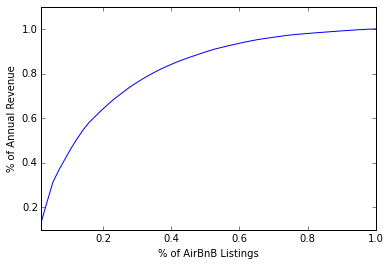

In [56]:
## Let's see who captures annual AiRBnB revenue in NYC. It looks like 20% of landlords capture almost 60% of revenue. 

test = GetIncomeDist(joined.dropna(subset=['annual_revenue']),'Bronx',whole_home=True)
PlotCDF(test,y_label='% of Annual Revenue')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(....) is deprecated, use sort_index(.....)


(0, 1)

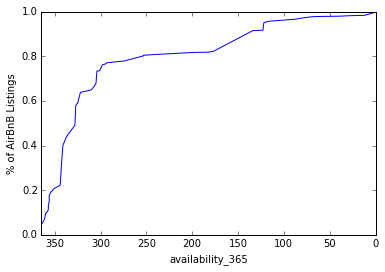

In [60]:
## Let's see what % of listings are available throughout the year, it looks like 80% of listings are available at least
## 300+ days

by_avail = test.reset_index().set_index('availability_365').sort(ascending=False)
by_avail['IncomeSumByAvail'] = by_avail.IncomeDist.cumsum()

by_avail['IncomeSumByAvail'].plot()

plt.ylabel('% of AirBnB Listings')
plt.ylim([0,1])

In [47]:
## my plots looked like they weren't increasing monotonically, which would be nonsensical , so I'm checking
## this 

def monotonic(x):
    return np.all(np.diff(x) > 0)

monotonic(by_avail['IncomeSumByAvail'].values)

True